## Test a repeatable data loading & modeling workflow

In [1]:
from __future__ import division
from dbhelper import pd_query
from modelhelper import cvfolds, plot_waittimes
import pandas as pd
from sklearn.metrics import r2_score
import matplotlib.pyplot as plt
%matplotlib inline

In [318]:
query = '''
        select 
            c.date,
            waittime,
            year,
            month,
            dayofmonth,
            week,
            dayofweek,
            EXTRACT(MINUTE FROM time - '00:00:00'::time) + 60 * EXTRACT(HOUR FROM time - '00:00:00'::time) minofday
        from crossingdata c
        join datefeatures d on c.date = d.date
        where
            valid=1
            and waittime is not null
            and crossing_id = 1
        order by c.date
        '''

df_all = pd_query(query)

## Test a Random Forest using year and day of week

In [319]:
from sklearn.ensemble import RandomForestRegressor
from sklearn.grid_search import GridSearchCV

In [323]:
from BorderModel import BorderData, clean_df_subset
dfnew = clean_df_subset(df_all, ['year', 'dayofweek', 'minofday'])
data = BorderData(dfnew)

In [321]:
model = RandomForestRegressor(n_jobs=-1, n_estimators=100, oob_score=True)
params = {}
grid = GridSearchCV(model, params, cv=data.cv_train)
grid.fit(data.X_train, data.y_train)

GridSearchCV(cv=array([[ [0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 15, 16, 17, 18, 19, 20, 21, 22, 23, 24, 25, 26, 27, 28, 29, 30, 31, 32, 33, 34, 35, 36, 37, 38, 39, 40, 41, 42, 43, 44, 45, 46, 47, 48, 49, 50, 51, 52, 53, 54, 55, 56, 57, 58, 59, 60, 61, 62, 63, 64, 65, 66, 67, 68, 69, 70, 71, 72, 73, 7...40, 735841, 735842, 735843, 735844, 735845, 735846, 735847, 735848, 735849, 735850]]], dtype=object),
       error_score='raise',
       estimator=RandomForestRegressor(bootstrap=True, criterion='mse', max_depth=None,
           max_features='auto', max_leaf_nodes=None, min_samples_leaf=1,
           min_samples_split=2, min_weight_fraction_leaf=0.0,
           n_estimators=100, n_jobs=-1, oob_score=True, random_state=None,
           verbose=0, warm_start=False),
       fit_params={}, iid=True, n_jobs=1, param_grid={},
       pre_dispatch='2*n_jobs', refit=True, scoring=None, verbose=0)

OOB:  0.509665781657
** MSE for last cv fold **
Baseline :  107.196129458
Model    :  107.237467029
** R^2 for last cv fold **
Baseline :  0.143442299388
Model    :  0.143111988819
** Explained variance for last cv fold **
Baseline :  0.284593975597
Model    :  0.284213755195


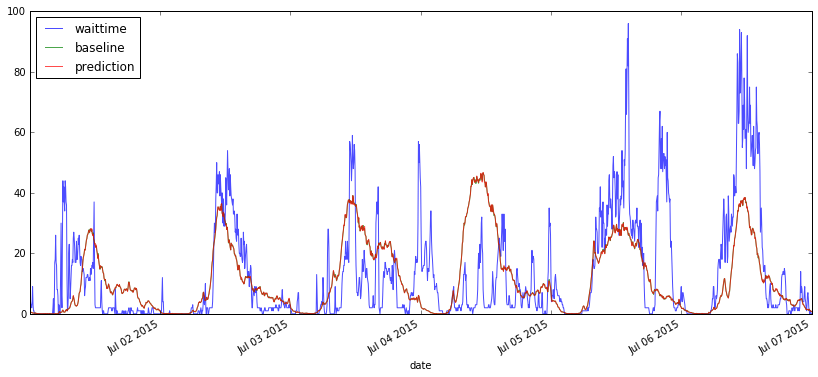

In [324]:
data.predict(grid.best_estimator_)
data.print_metrics(grid.best_estimator_)
data.plot('7/1/15', '7/7/15');

## Matches average by day of week!!!

## Run with 1 hour samples to expedite testing

In [325]:
query = '''
        select 
            c.date,
            waittime,
            year,
            month,
            dayofmonth,
            week,
            dayofweek,
            EXTRACT(MINUTE FROM time - '00:00:00'::time) + 60 * EXTRACT(HOUR FROM time - '00:00:00'::time) minofday
        from crossingdata c
        join datefeatures d on c.date = d.date
        where
            valid=1
            and waittime is not null
            and crossing_id = 1
            and EXTRACT(MINUTE FROM time - '00:00:00'::time) = 0
        order by c.date
        '''

df = pd_query(query)

In [326]:
from BorderModel import BorderData, clean_df_subset
dfnew = clean_df_subset(df, ['year', 'month', 'dayofweek', 'minofday'])
data = BorderData(dfnew, years=4)

In [327]:
model = RandomForestRegressor(n_jobs=-1, n_estimators=100, oob_score=True)
params = {}
grid = GridSearchCV(model, params, cv=data.cv_train)
grid.fit(data.X_train, data.y_train)

GridSearchCV(cv=array([[ [0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 15, 16, 17, 18, 19, 20, 21, 22, 23, 24, 25, 26, 27, 28, 29, 30, 31, 32, 33, 34, 35, 36, 37, 38, 39, 40, 41, 42, 43, 44, 45, 46, 47, 48, 49, 50, 51, 52, 53, 54, 55, 56, 57, 58, 59, 60, 61, 62, 63, 64, 65, 66, 67, 68, 69, 70, 71, 72, 73, 7...61254, 61255, 61256, 61257, 61258, 61259, 61260, 61261, 61262, 61263, 61264, 61265]]], dtype=object),
       error_score='raise',
       estimator=RandomForestRegressor(bootstrap=True, criterion='mse', max_depth=None,
           max_features='auto', max_leaf_nodes=None, min_samples_leaf=1,
           min_samples_split=2, min_weight_fraction_leaf=0.0,
           n_estimators=100, n_jobs=-1, oob_score=True, random_state=None,
           verbose=0, warm_start=False),
       fit_params={}, iid=True, n_jobs=1, param_grid={},
       pre_dispatch='2*n_jobs', refit=True, scoring=None, verbose=0)

OOB:  0.504585747687
** MSE for last cv fold **
Baseline :  108.775399841
Model    :  121.241682963
** R^2 for last cv fold **
Baseline :  0.141622879007
Model    :  0.0432479501979
** Explained variance for last cv fold **
Baseline :  0.276000553853
Model    :  0.182034853949


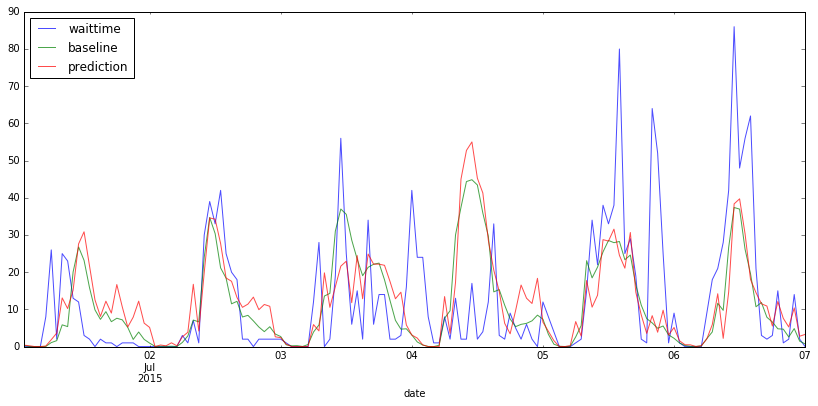

In [328]:
data.predict(grid.best_estimator_)
data.print_metrics(grid.best_estimator_)
data.plot('7/1/15', '7/7/15');

## Now that the workflow is efficient, modeling of date features can continue
Things to try:
1. year/dayofweek/minofday for different number of years.  It is still somewhat surprising that the 3 year model matches the baseline almost exactly
2. try other date features
3. try different models

## Work with 30 minute data
Note that datefeatures table has been updated with hour, minute and minofday columns

In [329]:
query = '''
        select 
            c.date,
            waittime,
            year,
            month,
            dayofmonth,
            week,
            dayofweek,
            minofday
        from crossingdata c
        join datefeatures d on c.date = d.date
        where
            valid=1
            and waittime is not null
            and crossing_id = 1
            and (minute = 0 or minute = 30)
        order by c.date
        '''

df = pd_query(query)

In [330]:
dfnew = clean_df_subset(df, ['year', 'dayofweek', 'minofday'])
data = BorderData(dfnew, years=4)

In [331]:
model = RandomForestRegressor(n_jobs=-1, n_estimators=100, oob_score=True)
params = {}
grid = GridSearchCV(model, params, cv=data.cv_train)
grid.fit(data.X_train, data.y_train)

GridSearchCV(cv=array([[ [0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 15, 16, 17, 18, 19, 20, 21, 22, 23, 24, 25, 26, 27, 28, 29, 30, 31, 32, 33, 34, 35, 36, 37, 38, 39, 40, 41, 42, 43, 44, 45, 46, 47, 48, 49, 50, 51, 52, 53, 54, 55, 56, 57, 58, 59, 60, 61, 62, 63, 64, 65, 66, 67, 68, 69, 70, 71, 72, 73, 7...75, 122576, 122577, 122578, 122579, 122580, 122581, 122582, 122583, 122584, 122585]]], dtype=object),
       error_score='raise',
       estimator=RandomForestRegressor(bootstrap=True, criterion='mse', max_depth=None,
           max_features='auto', max_leaf_nodes=None, min_samples_leaf=1,
           min_samples_split=2, min_weight_fraction_leaf=0.0,
           n_estimators=100, n_jobs=-1, oob_score=True, random_state=None,
           verbose=0, warm_start=False),
       fit_params={}, iid=True, n_jobs=1, param_grid={},
       pre_dispatch='2*n_jobs', refit=True, scoring=None, verbose=0)

OOB:  0.510101968111
** MSE for last cv fold **
Baseline :  107.994317561
Model    :  108.168559742
** R^2 for last cv fold **
Baseline :  0.146053496169
Model    :  0.144675706068
** Explained variance for last cv fold **
Baseline :  0.282901756576
Model    :  0.282262278462


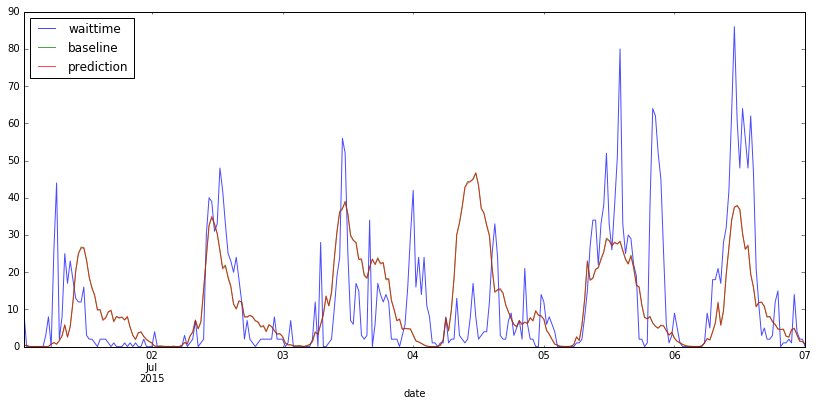

In [332]:
data.predict(grid.best_estimator_)
data.print_metrics(grid.best_estimator_)
data.plot('7/1/15', '7/7/15');

In [333]:
dfnew = clean_df_subset(df, ['year', 'dayofweek', 'minofday'])
data = BorderData(dfnew, years=5)

In [334]:
model = RandomForestRegressor(n_jobs=-1, n_estimators=100, oob_score=True)
params = {}
grid = GridSearchCV(model, params, cv=data.cv_train)
grid.fit(data.X_train, data.y_train)

GridSearchCV(cv=array([[ [0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 15, 16, 17, 18, 19, 20, 21, 22, 23, 24, 25, 26, 27, 28, 29, 30, 31, 32, 33, 34, 35, 36, 37, 38, 39, 40, 41, 42, 43, 44, 45, 46, 47, 48, 49, 50, 51, 52, 53, 54, 55, 56, 57, 58, 59, 60, 61, 62, 63, 64, 65, 66, 67, 68, 69, 70, 71, 72, 73, 7...75, 122576, 122577, 122578, 122579, 122580, 122581, 122582, 122583, 122584, 122585]]], dtype=object),
       error_score='raise',
       estimator=RandomForestRegressor(bootstrap=True, criterion='mse', max_depth=None,
           max_features='auto', max_leaf_nodes=None, min_samples_leaf=1,
           min_samples_split=2, min_weight_fraction_leaf=0.0,
           n_estimators=100, n_jobs=-1, oob_score=True, random_state=None,
           verbose=0, warm_start=False),
       fit_params={}, iid=True, n_jobs=1, param_grid={},
       pre_dispatch='2*n_jobs', refit=True, scoring=None, verbose=0)

OOB:  0.510207953949
** MSE for last cv fold **
Baseline :  107.994317561
Model    :  108.245045857
** R^2 for last cv fold **
Baseline :  0.146053496169
Model    :  0.144070905263
** Explained variance for last cv fold **
Baseline :  0.282901756576
Model    :  0.281524620526


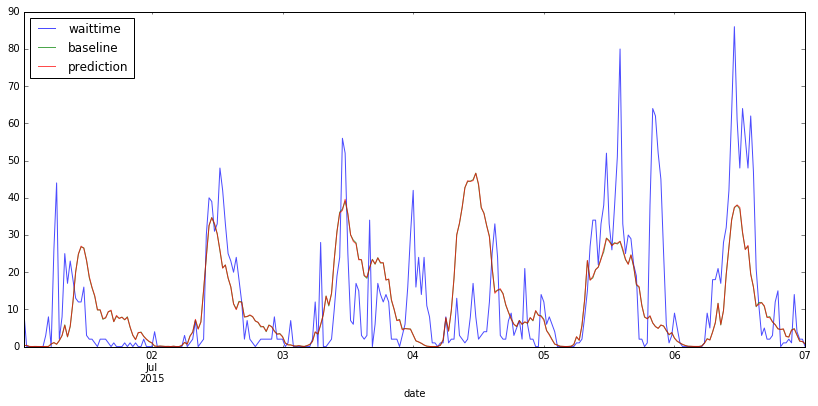

In [335]:
data.predict(grid.best_estimator_)
data.print_metrics(grid.best_estimator_)
data.plot('7/1/15', '7/7/15');

## No change to RF prediction regardless of number of years

## Verify that CV code looks right

In [343]:
for fold in data.cv_train:
    print min(fold[0]), max(fold[0]), min(fold[1]), max(fold[1])

0 55499 55500 72354
14555 72354 72355 88553
26671 88553 88554 105293
44017 105293 105294 122585


In [349]:
for year in range(2007, 2015):
    print year, df[df.year==year].index.min(), df[df.year==year].index.max()

2007 0 14554
2008 14555 26670
2009 26671 44016
2010 44017 55499
2011 55500 72354
2012 72355 88553
2013 88554 105293
2014 105294 122585


## Try linear regression

In [364]:
model = LinearRegression(normalize=True, n_jobs=-1)
params = {}
grid = GridSearchCV(model, params, cv=data.cv_train)
grid.fit(data.X_train, data.y_train)

GridSearchCV(cv=array([[ [0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 15, 16, 17, 18, 19, 20, 21, 22, 23, 24, 25, 26, 27, 28, 29, 30, 31, 32, 33, 34, 35, 36, 37, 38, 39, 40, 41, 42, 43, 44, 45, 46, 47, 48, 49, 50, 51, 52, 53, 54, 55, 56, 57, 58, 59, 60, 61, 62, 63, 64, 65, 66, 67, 68, 69, 70, 71, 72, 73, 7...75, 122576, 122577, 122578, 122579, 122580, 122581, 122582, 122583, 122584, 122585]]], dtype=object),
       error_score='raise',
       estimator=LinearRegression(copy_X=True, fit_intercept=True, n_jobs=-1, normalize=True),
       fit_params={}, iid=True, n_jobs=1, param_grid={},
       pre_dispatch='2*n_jobs', refit=True, scoring=None, verbose=0)

Best score:  -0.00145735401733
** MSE for last cv fold **
Baseline :  107.994317561
Model    :  127.024572901
** R^2 for last cv fold **
Baseline :  0.146053496169
Model    :  -0.00442497697133
** Explained variance for last cv fold **
Baseline :  0.282901756576
Model    :  0.0269009914569


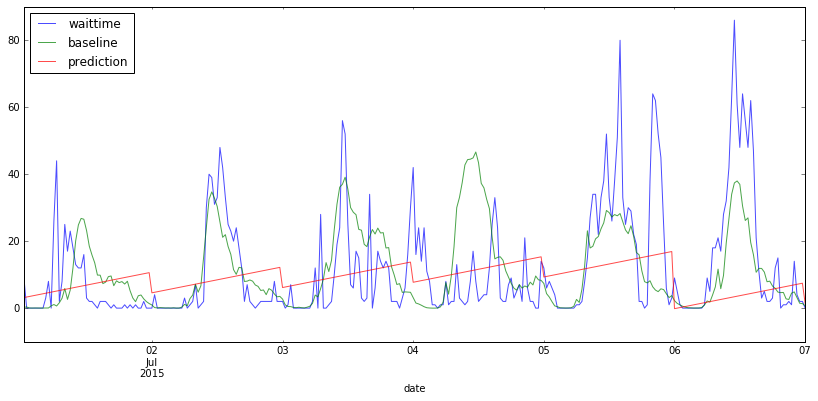

In [365]:
data.predict(grid.best_estimator_)
data.print_metrics(grid)
data.plot('7/1/15', '7/7/15');

In [359]:
dfnew = clean_df_subset(df, ['year', 'dayofweek', 'minofday'])
data = BorderData(dfnew, years=3)

In [360]:
model = LinearRegression(normalize=True)
params = {}
grid = GridSearchCV(model, params, cv=data.cv_train)
grid.fit(data.X_train, data.y_train)

GridSearchCV(cv=array([[ [0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 15, 16, 17, 18, 19, 20, 21, 22, 23, 24, 25, 26, 27, 28, 29, 30, 31, 32, 33, 34, 35, 36, 37, 38, 39, 40, 41, 42, 43, 44, 45, 46, 47, 48, 49, 50, 51, 52, 53, 54, 55, 56, 57, 58, 59, 60, 61, 62, 63, 64, 65, 66, 67, 68, 69, 70, 71, 72, 73, 7...75, 122576, 122577, 122578, 122579, 122580, 122581, 122582, 122583, 122584, 122585]]], dtype=object),
       error_score='raise',
       estimator=LinearRegression(copy_X=True, fit_intercept=True, n_jobs=1, normalize=True),
       fit_params={}, iid=True, n_jobs=1, param_grid={},
       pre_dispatch='2*n_jobs', refit=True, scoring=None, verbose=0)

Best score:  -0.00145735401733
** MSE for last cv fold **
Baseline :  107.994317561
Model    :  127.024572901
** R^2 for last cv fold **
Baseline :  0.146053496169
Model    :  -0.00442497697133
** Explained variance for last cv fold **
Baseline :  0.282901756576
Model    :  0.0269009914569


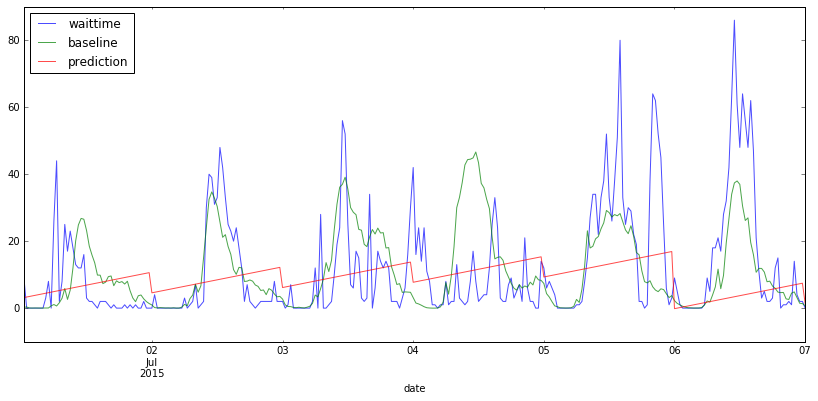

In [361]:
data.predict(grid.best_estimator_)
data.print_metrics(grid)
data.plot('7/1/15', '7/7/15');

### Linear regression is poor

## Try Gradient Boosting

In [366]:
from sklearn.ensemble import GradientBoostingRegressor

In [367]:
model = GradientBoostingRegressor(subsample=.2)
params = {}
grid = GridSearchCV(model, params, cv=data.cv_train)
grid.fit(data.X_train, data.y_train)

GridSearchCV(cv=array([[ [0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 15, 16, 17, 18, 19, 20, 21, 22, 23, 24, 25, 26, 27, 28, 29, 30, 31, 32, 33, 34, 35, 36, 37, 38, 39, 40, 41, 42, 43, 44, 45, 46, 47, 48, 49, 50, 51, 52, 53, 54, 55, 56, 57, 58, 59, 60, 61, 62, 63, 64, 65, 66, 67, 68, 69, 70, 71, 72, 73, 7...75, 122576, 122577, 122578, 122579, 122580, 122581, 122582, 122583, 122584, 122585]]], dtype=object),
       error_score='raise',
       estimator=GradientBoostingRegressor(alpha=0.9, init=None, learning_rate=0.1, loss='ls',
             max_depth=3, max_features=None, max_leaf_nodes=None,
             min_samples_leaf=1, min_samples_split=2,
             min_weight_fraction_leaf=0.0, n_estimators=100,
             presort='auto', random_state=None, subsample=0.2, verbose=0,
             warm_start=False),
       fit_params={}, iid=True, n_jobs=1, param_grid={},
       pre_dispatch='2*n_jobs', refit=True, scoring=None, verbose=0)

** MSE for last cv fold **
Baseline :  107.994317561
Model    :  118.051420315
** R^2 for last cv fold **
Baseline :  0.146053496169
Model    :  0.0665286847742
** Explained variance for last cv fold **
Baseline :  0.282901756576
Model    :  0.218160953111


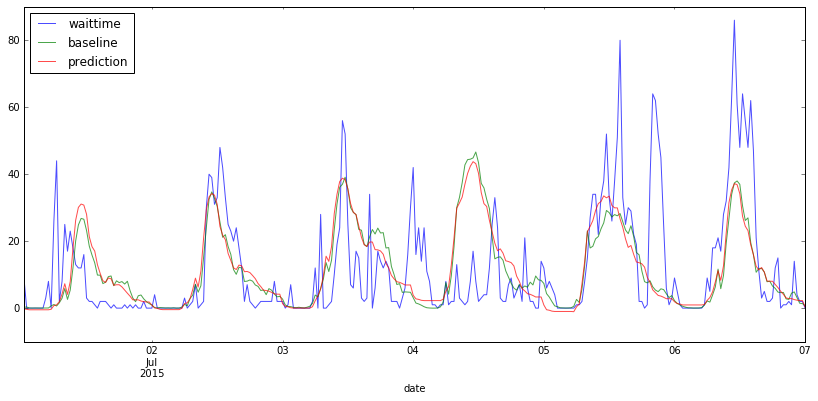

In [368]:
data.predict(grid.best_estimator_)
data.print_metrics(grid.best_estimator_)
data.plot('7/1/15', '7/7/15');

## Promising - more variation from baseline

** MSE for last cv fold **
Baseline :  107.994317561
Model    :  118.779747667
** R^2 for last cv fold **
Baseline :  0.146053496169
Model    :  0.0607695614234
** Explained variance for last cv fold **
Baseline :  0.282901756576
Model    :  0.212688156363


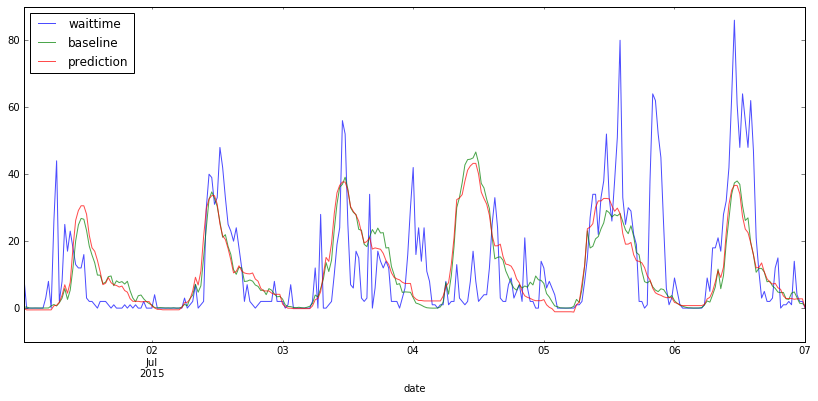

In [369]:
data = BorderData(dfnew, years=5)
model = GradientBoostingRegressor(subsample=.2)
params = {}
grid = GridSearchCV(model, params, cv=data.cv_train)
grid.fit(data.X_train, data.y_train)
data.predict(grid.best_estimator_)
data.print_metrics(grid.best_estimator_)
data.plot('7/1/15', '7/7/15');

** MSE for last cv fold **
Baseline :  107.994317561
Model    :  110.960153647
** R^2 for last cv fold **
Baseline :  0.146053496169
Model    :  0.122601657095
** Explained variance for last cv fold **
Baseline :  0.282901756576
Model    :  0.25881155207


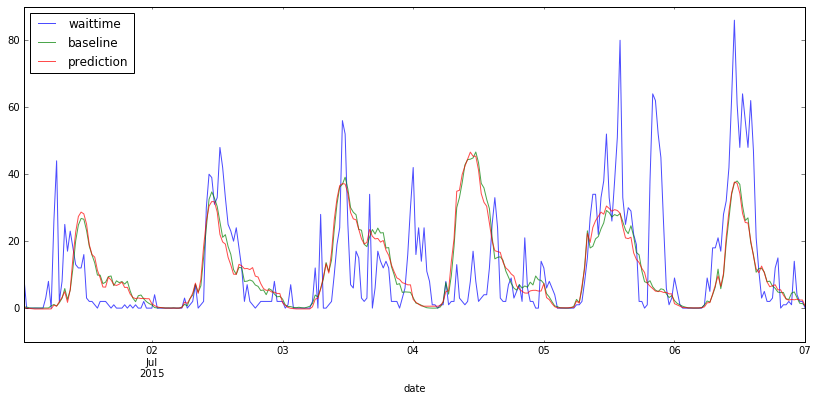

In [370]:
data = BorderData(dfnew, years=3)
model = GradientBoostingRegressor(subsample=.2)
params = {'learning_rate': [.03, .1, .3], 'n_estimators': [30, 100, 300]}
grid = GridSearchCV(model, params, cv=data.cv_train)
grid.fit(data.X_train, data.y_train)
data.predict(grid.best_estimator_)
data.print_metrics(grid.best_estimator_)
data.plot('7/1/15', '7/7/15');

In [371]:
grid.best_params_

{'learning_rate': 0.1, 'n_estimators': 300}

## GBR - add month feature

** MSE for last cv fold **
Baseline :  107.994317561
Model    :  113.047829512
** R^2 for last cv fold **
Baseline :  0.146053496169
Model    :  0.106093719027
** Explained variance for last cv fold **
Baseline :  0.282901756576
Model    :  0.244073782352


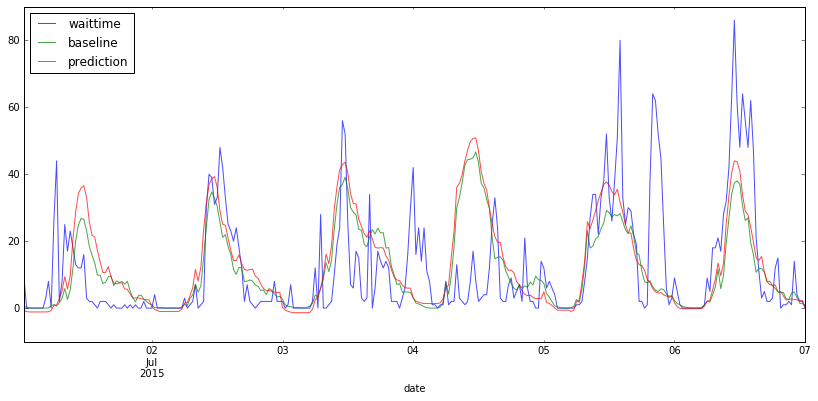

In [372]:
dfnew = clean_df_subset(df, ['year', 'month', 'dayofweek', 'minofday'])
data = BorderData(dfnew, years=3)
model = GradientBoostingRegressor(subsample=.2, n_estimators=300)
params = {}
grid = GridSearchCV(model, params, cv=data.cv_train)
grid.fit(data.X_train, data.y_train)
data.predict(grid.best_estimator_)
data.print_metrics(grid.best_estimator_)
data.plot('7/1/15', '7/7/15');

** MSE for last cv fold **
Baseline :  107.994317561
Model    :  114.530858604
** R^2 for last cv fold **
Baseline :  0.146053496169
Model    :  0.0943669213875
** Explained variance for last cv fold **
Baseline :  0.282901756576
Model    :  0.235847873115


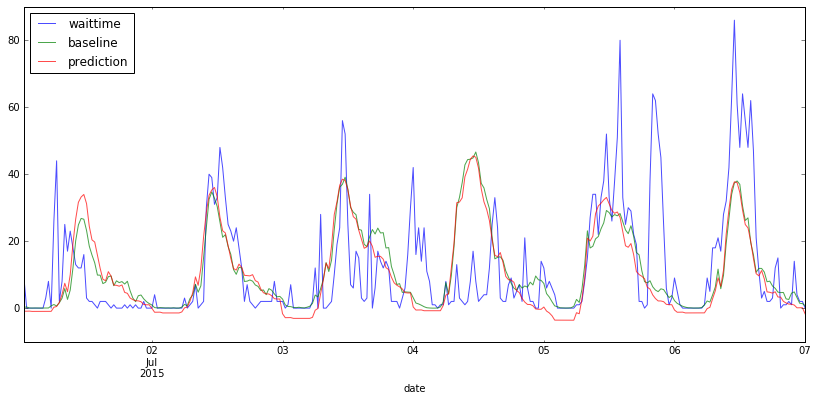

In [373]:
dfnew = clean_df_subset(df, ['year', 'dayofmonth', 'month', 'dayofweek', 'minofday'])
data = BorderData(dfnew, years=3)
model = GradientBoostingRegressor(subsample=.2, n_estimators=300)
params = {}
grid = GridSearchCV(model, params, cv=data.cv_train)
grid.fit(data.X_train, data.y_train)
data.predict(grid.best_estimator_)
data.print_metrics(grid.best_estimator_)
data.plot('7/1/15', '7/7/15');

** MSE for last cv fold **
Baseline :  107.994317561
Model    :  122.676432459
** R^2 for last cv fold **
Baseline :  0.146053496169
Model    :  0.0299571962036
** Explained variance for last cv fold **
Baseline :  0.282901756576
Model    :  0.190351137838


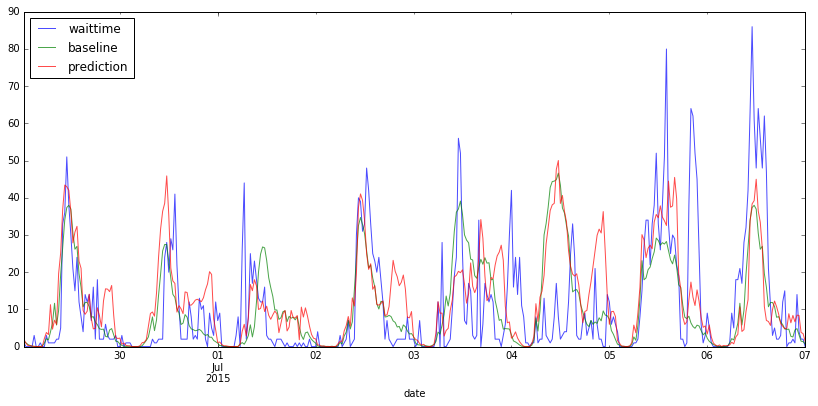

In [377]:
dfnew = clean_df_subset(df, ['year', 'dayofmonth', 'month', 'dayofweek', 'minofday'])
data = BorderData(dfnew, years=3)
model = RandomForestRegressor(n_jobs=-1, n_estimators=300)
params = {}
grid = GridSearchCV(model, params, cv=data.cv_train)
grid.fit(data.X_train, data.y_train)
data.predict(grid.best_estimator_)
data.print_metrics(grid.best_estimator_)
data.plot('6/29/15', '7/7/15');

** MSE for last cv fold **
Baseline :  107.994317561
Model    :  122.484865415
** R^2 for last cv fold **
Baseline :  0.146053496169
Model    :  0.0314719796755
** Explained variance for last cv fold **
Baseline :  0.282901756576
Model    :  0.19106915344


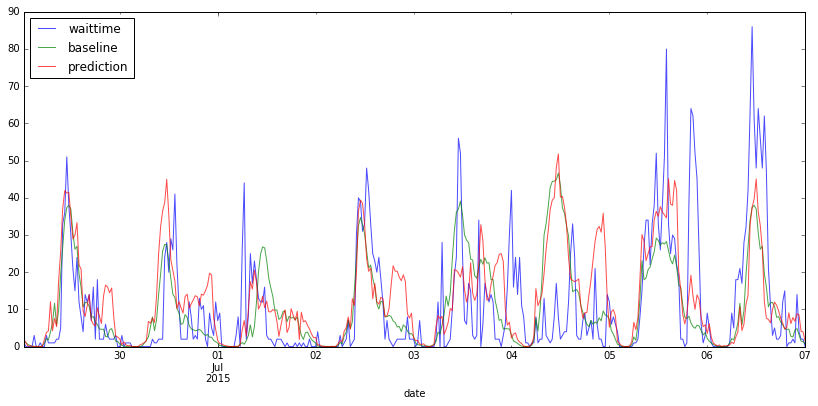

In [378]:
dfnew = clean_df_subset(df, ['year', 'dayofmonth', 'month', 'dayofweek', 'minofday'])
data = BorderData(dfnew, years=3)
model = RandomForestRegressor(n_jobs=-1, n_estimators=100)
params = {}
grid = GridSearchCV(model, params, cv=data.cv_train)
grid.fit(data.X_train, data.y_train)
data.predict(grid.best_estimator_)
data.print_metrics(grid.best_estimator_)
data.plot('6/29/15', '7/7/15');

** MSE for last cv fold **
Baseline :  107.994317561
Model    :  107.623224518
** R^2 for last cv fold **
Baseline :  0.146053496169
Model    :  0.148987850618
** Explained variance for last cv fold **
Baseline :  0.282901756576
Model    :  0.284408224607


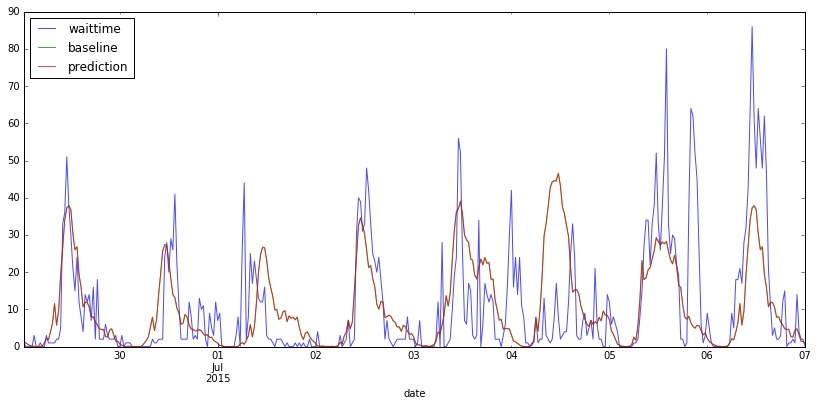

In [381]:
dfnew = clean_df_subset(df, ['year', 'dayofweek', 'minofday'])
data = BorderData(dfnew, years=3)
model = RandomForestRegressor(n_jobs=-1, n_estimators=100)
params = {}
grid = GridSearchCV(model, params, cv=data.cv_train)
grid.fit(data.X_train, data.y_train)
data.predict(grid.best_estimator_)
data.print_metrics(grid.best_estimator_)
data.plot('6/29/15', '7/7/15');

** MSE for last cv fold **
Baseline :  107.994317561
Model    :  119.700428688
** R^2 for last cv fold **
Baseline :  0.146053496169
Model    :  0.0534894345047
** Explained variance for last cv fold **
Baseline :  0.282901756576
Model    :  0.194930235552


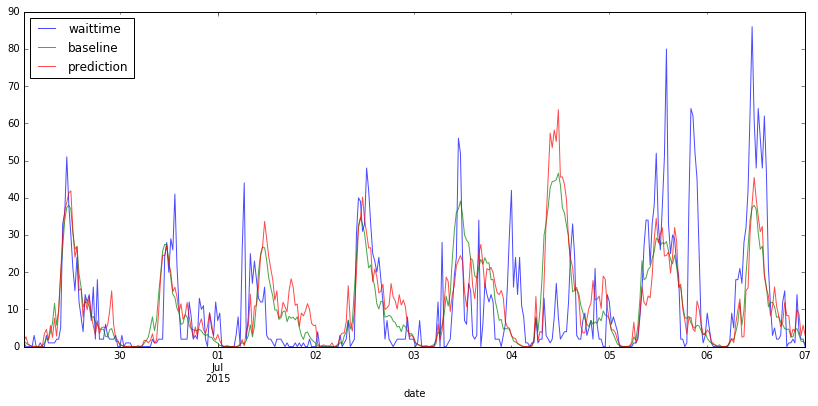

In [380]:
dfnew = clean_df_subset(df, ['year', 'month', 'dayofweek', 'minofday'])
data = BorderData(dfnew, years=3)
model = RandomForestRegressor(n_jobs=-1, n_estimators=100)
params = {}
grid = GridSearchCV(model, params, cv=data.cv_train)
grid.fit(data.X_train, data.y_train)
data.predict(grid.best_estimator_)
data.print_metrics(grid.best_estimator_)
data.plot('6/29/15', '7/7/15');

** MSE for last cv fold **
Baseline :  107.994317561
Model    :  119.831527388
** R^2 for last cv fold **
Baseline :  0.146053496169
Model    :  0.0524527940649
** Explained variance for last cv fold **
Baseline :  0.282901756576
Model    :  0.193474656926


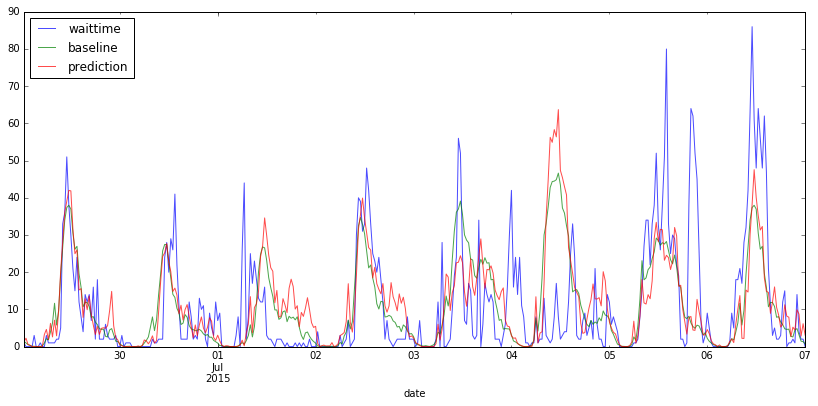

In [448]:
dfnew = clean_df_subset(df, ['year', 'month', 'dayofweek', 'minofday'])
data = BorderData(dfnew, years=5)
model = RandomForestRegressor(n_jobs=-1, n_estimators=100)
params = {}
grid = GridSearchCV(model, params, cv=data.cv_train)
grid.fit(data.X_train, data.y_train)
data.predict(grid.best_estimator_)
data.print_metrics(grid.best_estimator_)
data.plot('6/29/15', '7/7/15');

In [450]:
grid.best_score_

0.21392177842075061

In [449]:
import cPickle as pickle
with open('../models/rf_v0.1.small.pkl', 'w') as f:
    pickle.dump(grid.best_estimator_, f)

## Conclusions
* None of the models are beating baseline model
* Random forest with only year/dayofweek/minofday will predice the baseline almost exactly
* GBR does not overfit as much as RF with more features

### The model is not strong with just date features.  Time to investigate new features.

## Sanity check: Similar behavior when estimating for different years

In [388]:
df2014 = df[df.date < '2015']

** MSE for last cv fold **
Baseline :  99.8672948257
Model    :  116.457036278
** R^2 for last cv fold **
Baseline :  0.536521408378
Model    :  0.459529335876
** Explained variance for last cv fold **
Baseline :  0.540455997203
Model    :  0.463761045902


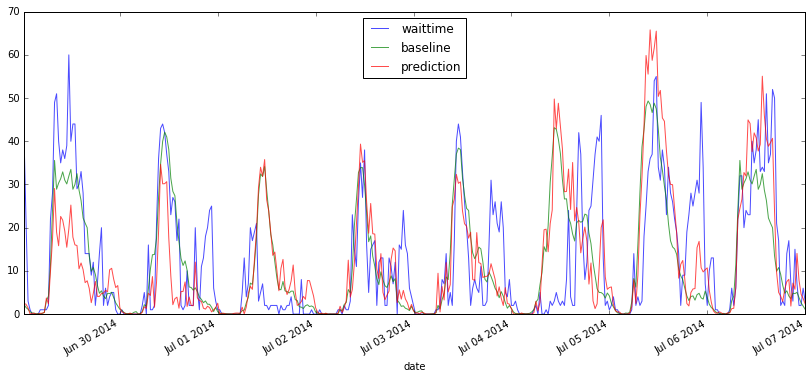

In [390]:
dfnew = clean_df_subset(df2014, ['year', 'month', 'dayofweek', 'minofday'])
data = BorderData(dfnew, years=5)
model = RandomForestRegressor(n_jobs=-1, n_estimators=100)
params = {}
grid = GridSearchCV(model, params, cv=data.cv_train)
grid.fit(data.X_train, data.y_train)
data.predict(grid.best_estimator_)
data.print_metrics(grid.best_estimator_)
data.plot('6/29/14', '7/7/14');

## Pickle a full model to test web app end-to-end

In [395]:
# from BorderModel import BorderData
dfnew = clean_df_subset(df_all, ['year', 'month', 'dayofweek', 'minofday'])
data = BorderData(dfnew, years=3)
model = RandomForestRegressor(n_jobs=-1, n_estimators=100)
params = {}
grid = GridSearchCV(model, params, cv=data.cv)
grid.fit(data.X, data.y)

GridSearchCV(cv=array([[ [0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 15, 16, 17, 18, 19, 20, 21, 22, 23, 24, 25, 26, 27, 28, 29, 30, 31, 32, 33, 34, 35, 36, 37, 38, 39, 40, 41, 42, 43, 44, 45, 46, 47, 48, 49, 50, 51, 52, 53, 54, 55, 56, 57, 58, 59, 60, 61, 62, 63, 64, 65, 66, 67, 68, 69, 70, 71, 72, 73, 7...60, 829161, 829162, 829163, 829164, 829165, 829166, 829167, 829168, 829169, 829170]]], dtype=object),
       error_score='raise',
       estimator=RandomForestRegressor(bootstrap=True, criterion='mse', max_depth=None,
           max_features='auto', max_leaf_nodes=None, min_samples_leaf=1,
           min_samples_split=2, min_weight_fraction_leaf=0.0,
           n_estimators=100, n_jobs=-1, oob_score=False, random_state=None,
           verbose=0, warm_start=False),
       fit_params={}, iid=True, n_jobs=1, param_grid={},
       pre_dispatch='2*n_jobs', refit=True, scoring=None, verbose=0)

In [399]:
grid.best_score_

0.16356649484389149

In [398]:
import cPickle as pickle
with open('../models/rf_v0.1.pkl', 'w') as f:
    pickle.dump(grid.best_estimator_, f)

### Verify this makes sense...

1. Web app takes date range as input
2. Construct features based on date range
    a. Query DB for features.  Assumes features are already in DB.  We can use 
    b. Run model

In [435]:
import datetime
start = datetime.datetime(2016, 2, 19)
end = start + datetime.timedelta(hours=24)

query = '''
        select year, month, dayofweek, minofday
        from datefeatures
        where date >= '%s' and date < '%s'
        order by date
        '''
feature_df = pd_query(query, (str(start), str(end)))


In [439]:
yhat = grid.best_estimator_.predict(feature_df)

In [445]:
datetime.time() + datetime.timedelta(0,3)

TypeError: unsupported operand type(s) for +: 'datetime.time' and 'datetime.timedelta'

In [447]:
type(yhat)

numpy.ndarray